# Seccion 1

### 1. Visualicen los datos para ver si pueden detectar algunos grupos. **Ayuda:**   utilicen la forma del sépalo:

#### Importamos las librerias

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from kneed import KneeLocator
from sklearn.metrics import adjusted_rand_score

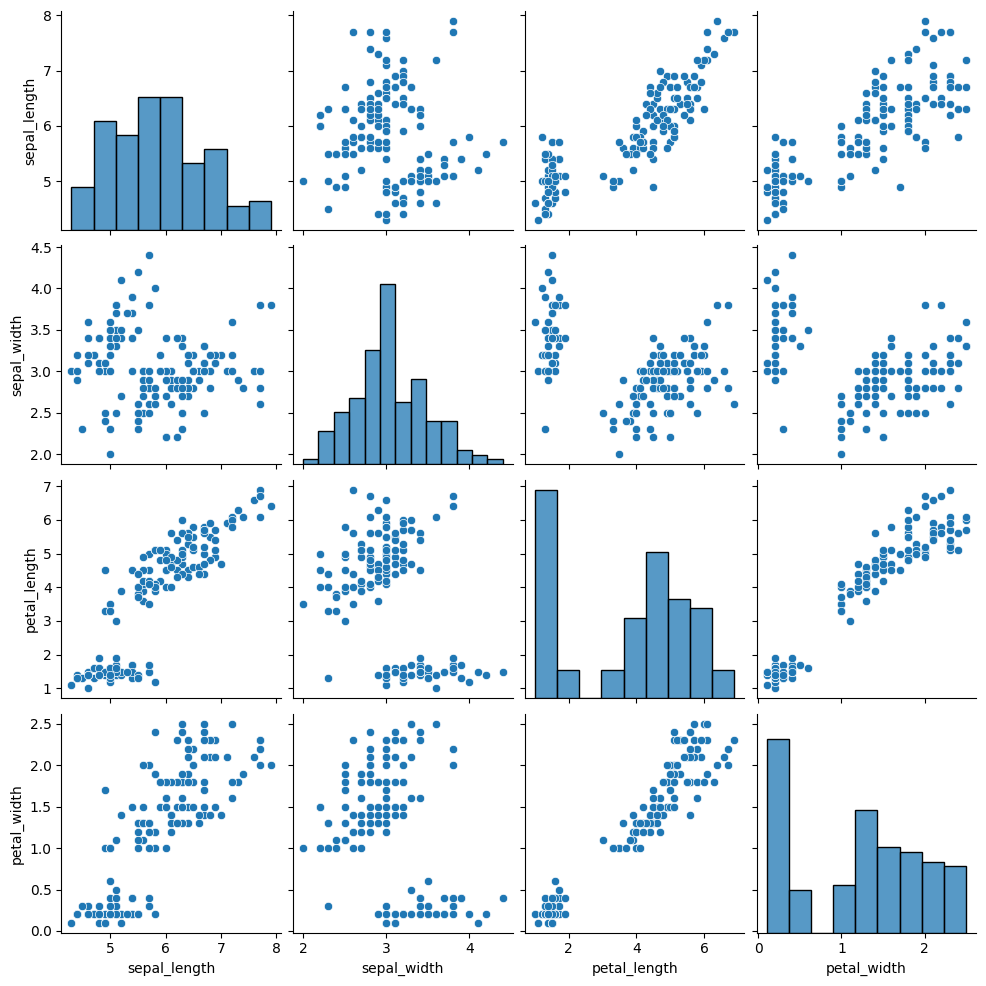

In [69]:
data = pd.read_csv("iris.csv")
sns.pairplot(data)
plt.show()

### 2. Creen 2 "clusters" utilizando K_Means Clustering y grafiquen los resultados.  

c:\Users\Jessica Ortiz\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


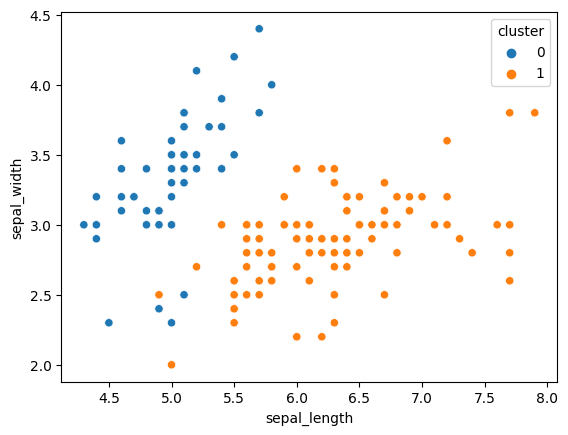

In [70]:
kmeans = KMeans(n_clusters=2)
data["cluster"] = kmeans.fit_predict(data)

sns.scatterplot(data=data, x="sepal_length", y="sepal_width", hue="cluster")
plt.show()

### 3. Estandaricen los datos e intenten el paso 2, de nuevo.  ¿Qué diferencias hay, si es que lo hay?

c:\Users\Jessica Ortiz\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


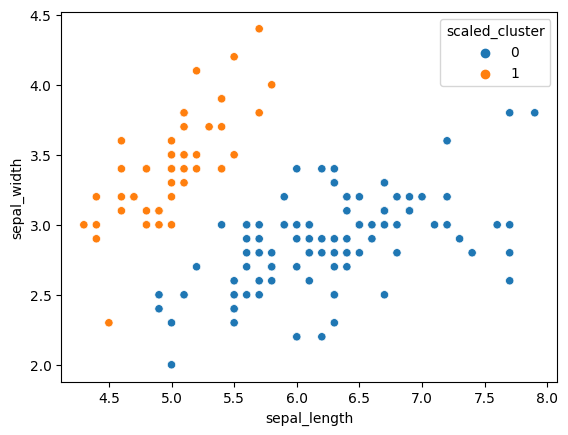

In [71]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data.drop(columns=["cluster"]))

kmeans = KMeans(n_clusters=2)
data["scaled_cluster"] = kmeans.fit_predict(scaled_data)

sns.scatterplot(data=data, x="sepal_length", y="sepal_width", hue="scaled_cluster")
plt.show()

### 4. Utilicen el método del "codo" para determinar cuantos "clusters" es el ideal. (prueben un rango de 1 a 10)

c:\Users\Jessica Ortiz\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Jessica Ortiz\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Jessica Ortiz\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Jessica Ortiz\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 

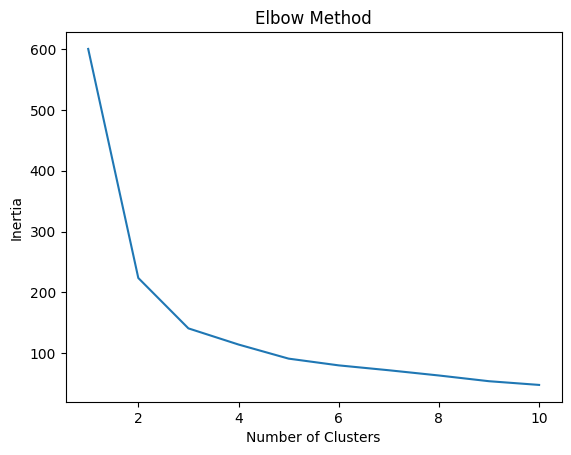

In [72]:
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia)
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

### 5. Basado en la gráfica del "codo" realicen varias gráficas con el número de clusters (unos 3 o 4 diferentes) que Uds creen mejor se ajusten a los datos.

c:\Users\Jessica Ortiz\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


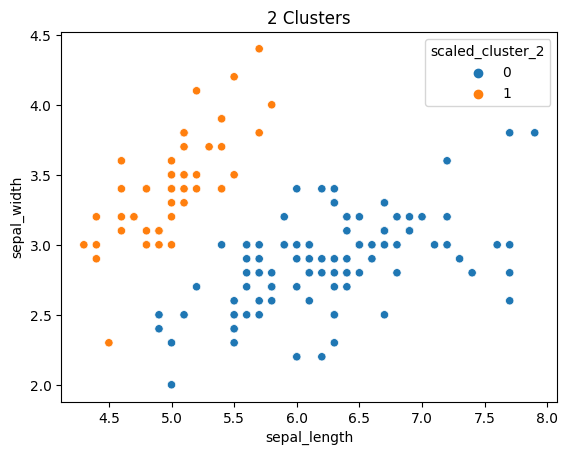

c:\Users\Jessica Ortiz\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


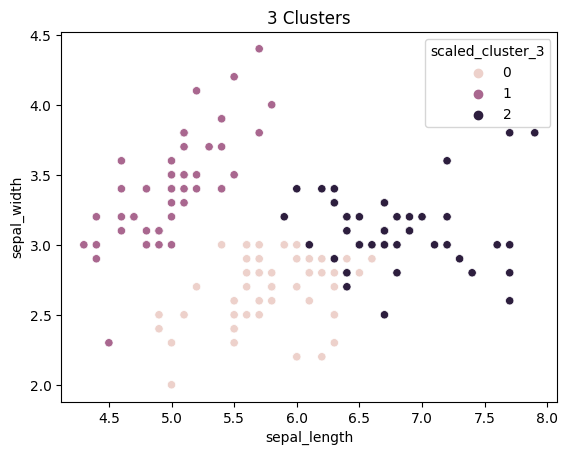

c:\Users\Jessica Ortiz\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


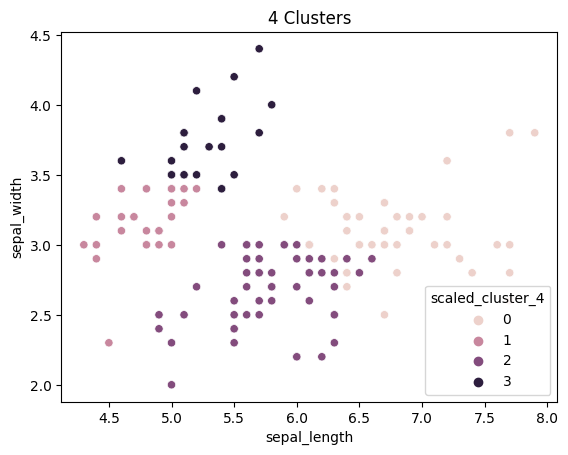

c:\Users\Jessica Ortiz\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


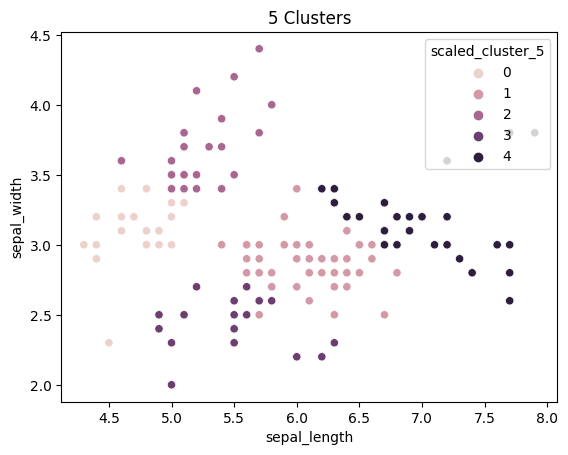

In [73]:
for clusters in [2, 3, 4, 5]:
    kmeans = KMeans(n_clusters=clusters)
    data[f"scaled_cluster_{clusters}"] = kmeans.fit_predict(scaled_data)

    sns.scatterplot(
        data=data, x="sepal_length", y="sepal_width", hue=f"scaled_cluster_{clusters}"
    )
    plt.title(f"{clusters} Clusters")
    plt.show()

### 6. Comparen sus soluciones con los datos reales, archivo: *iris-con-respuestas.csv*

0    53
2    50
1    47
dtype: int64
Adjusted Rand Index: 0.59


c:\Users\Jessica Ortiz\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Jessica Ortiz\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


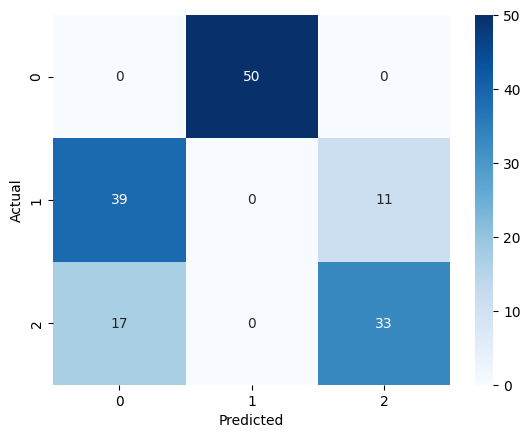

In [74]:
# Comparar con los datos reales
real_data = pd.read_csv("iris-con-respuestas.csv")

species_mapping = {"setosa": 0, "versicolor": 1, "virginica": 2}
real_data["species"] = real_data["species"].map(species_mapping)

# Comparar los clusters con las etiquetas reales
kmeans = KMeans(n_clusters=3)
kmeans.fit(data)
pred = kmeans.predict(data)

print(pd.Series(pred).value_counts())

scaled_data = scaler.fit_transform(real_data.drop(columns=["species"]))
real_data["scaled_cluster"] = kmeans.fit_predict(scaled_data)

# Calcular la matriz de confusión
cm = confusion_matrix(real_data["species"], real_data["scaled_cluster"])
classes = unique_labels(real_data["species"], real_data["scaled_cluster"])

# Calculate the Adjusted Rand Index
ari = adjusted_rand_score(
    real_data["species"], real_data["scaled_cluster"]
)  # Add this line
print(f"Adjusted Rand Index: {ari:.2f}")

# Visualizar la matriz de confusión
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=classes,
    yticklabels=classes,
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Seccion 2

### Repitan el proceso pero ahora utilizando la forma del pétalo.  Respondan a las mismas preguntas


#### Importamos las librerias

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from kneed import KneeLocator
from sklearn.metrics import adjusted_rand_score

### Visualizar los datos

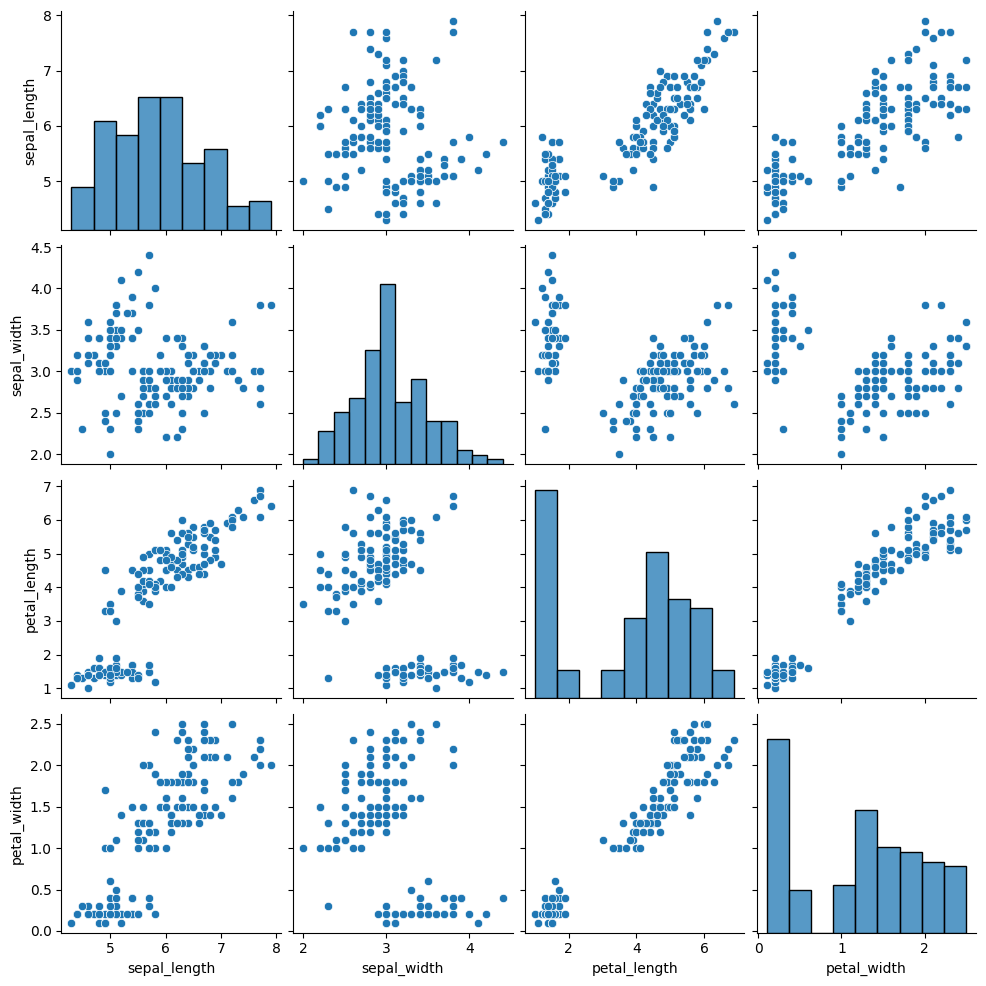

In [76]:
data = pd.read_csv("iris.csv")
sns.pairplot(data)
plt.show()

### Crear 2 clusters utilizando KMeans Clustering y graficar los resultados:

c:\Users\Jessica Ortiz\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


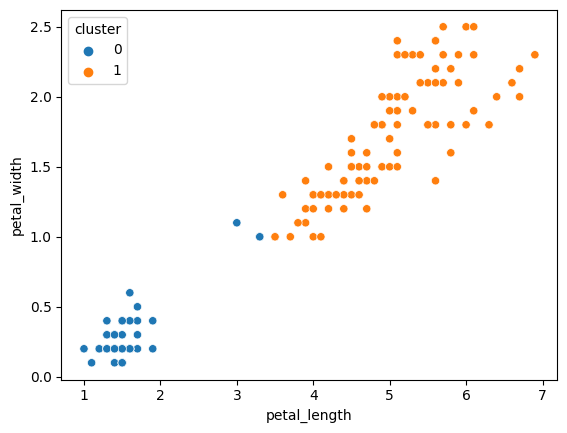

In [77]:
kmeans = KMeans(n_clusters=2)
data["cluster"] = kmeans.fit_predict(data)

sns.scatterplot(data=data, x="petal_length", y="petal_width", hue="cluster")
plt.show()

### Estandarizar los datos e intentar el paso 2 de nuevo:

c:\Users\Jessica Ortiz\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


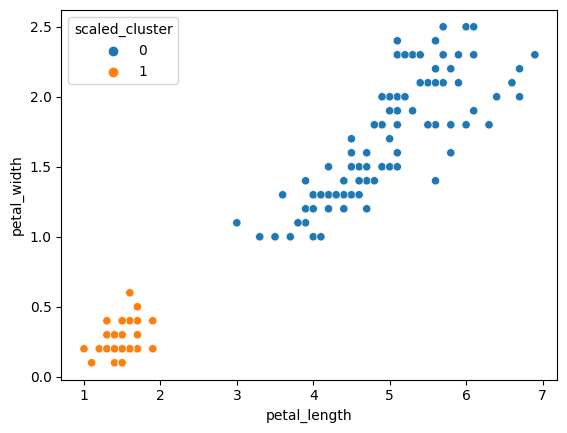

In [78]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data.drop(columns=["cluster"]))

kmeans = KMeans(n_clusters=2)
data["scaled_cluster"] = kmeans.fit_predict(scaled_data)

sns.scatterplot(data=data, x="petal_length", y="petal_width", hue="scaled_cluster")
plt.show()

### Utilizar el método del "codo" para determinar el número ideal de clusters:

c:\Users\Jessica Ortiz\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Jessica Ortiz\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Jessica Ortiz\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Jessica Ortiz\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 

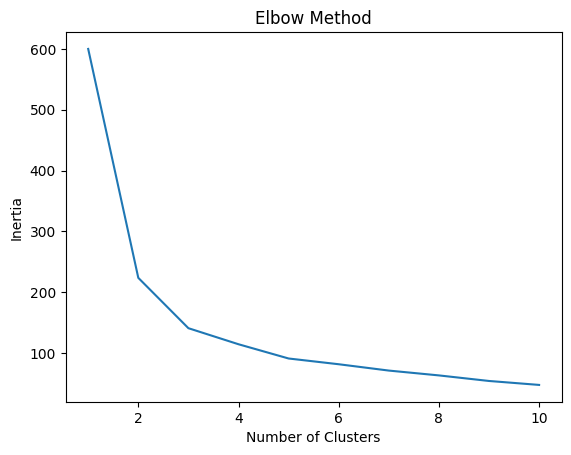

In [79]:
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia)
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

### Graficar con diferentes números de clusters:

c:\Users\Jessica Ortiz\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


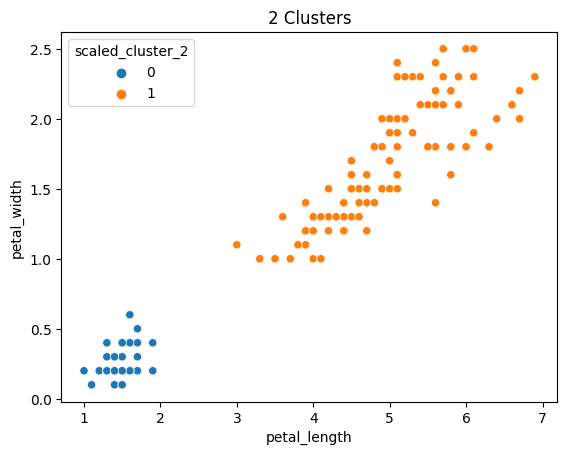

c:\Users\Jessica Ortiz\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


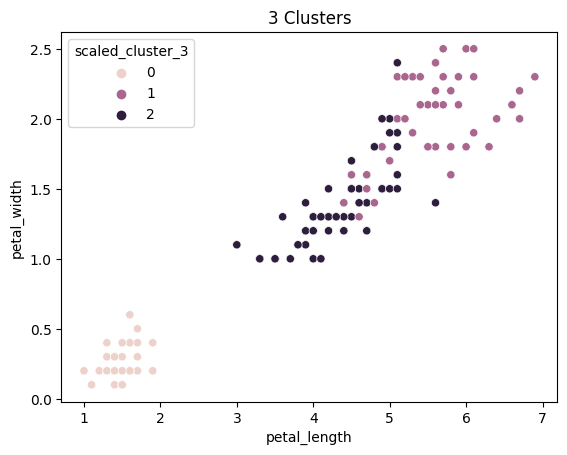

c:\Users\Jessica Ortiz\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


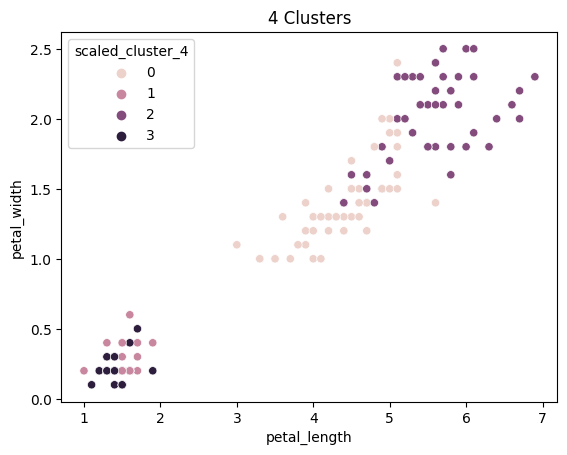

c:\Users\Jessica Ortiz\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


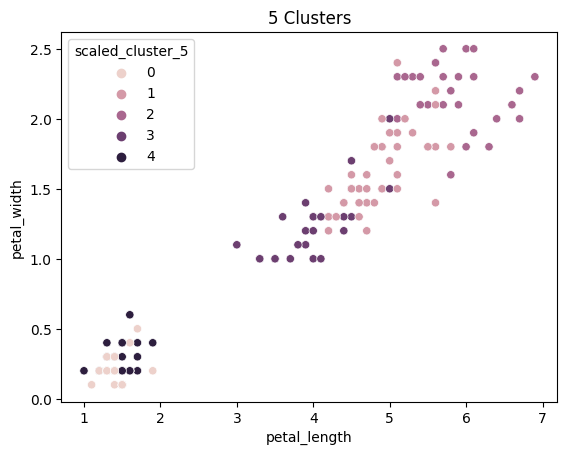

In [80]:
for clusters in [2, 3, 4, 5]:
    kmeans = KMeans(n_clusters=clusters)
    data[f"scaled_cluster_{clusters}"] = kmeans.fit_predict(scaled_data)

    sns.scatterplot(
        data=data, x="petal_length", y="petal_width", hue=f"scaled_cluster_{clusters}"
    )
    plt.title(f"{clusters} Clusters")
    plt.show()

### Comparar con los datos reales:

In [81]:
real_data = pd.read_csv("iris-con-respuestas.csv")
species_mapping = {"setosa": 0, "versicolor": 1, "virginica": 2}
real_data["species_label"] = real_data["species"].map(species_mapping)

# Calcular la matriz de confusión (usando el número óptimo de clusters que hayas encontrado, aquí asumimos 3 clusters)
kmeans = KMeans(n_clusters=3)
data["scaled_cluster"] = kmeans.fit_predict(scaled_data)

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(real_data["species_label"], data["scaled_cluster"])


# Calculate the Adjusted Rand Index
ari = adjusted_rand_score(
    real_data["species"], real_data["scaled_cluster"]
)  # Add this line
print(f"Adjusted Rand Index: {ari:.2f}")


# Visualizar la matriz de confusión
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=species_mapping.keys(),
    yticklabels=species_mapping.keys(),
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

c:\Users\Jessica Ortiz\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KeyError: 'scaled_cluster'

# Seccion 3

### De seccion 1

In [ ]:
# Seccion 3
kneedle = KneeLocator(range(1, 11), inertia, curve="convex", direction="decreasing")
print(f"\nNúmero óptimo de clusters según kneed: {kneedle.elbow}\n")

### De seccion 2

In [ ]:
# Seccion 3
kneedle = KneeLocator(range(1, 11), inertia, curve="convex", direction="decreasing")
print(f"\nNúmero óptimo de clusters según kneed: {kneedle.elbow}\n")